## Envrionment Setup

- Run `conda env create --name avalon --file=environment.yaml`
- Then switch to the environment by clicking the `avalon` item of the drop-down in the top right corner of Jupyter Notebook.

# Crime Forecast in Vancouver

by Ben Chen, Mo Norouzi, Orix Au Yeung, Yiwei Zhang

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import sys
warnings.filterwarnings("ignore")
sys.path.append('../src/helpers')
sys.path.append('../src') 

from get_metrics_from_df import get_metrics_from_df
from missing_value import missing_zero_values_table

# Summary

In this notebook, our focus revolved around constructing a time-series forecasting model tailored to predict crime incidents in Vancouver, using "Month" as the temporal unit. Our primary emphasis centered on one of the most prevalent crime types in Vancouver over the past two decades: theft from vehicles. We evaluated the efficacy of three fundamental forecasting models—simple moving average, exponential smoothing, and ARIMA(1,1,0). Notably, the ARIMA(1,1,0) model emerged as the most effective, yielding a Mean Absolute Error (MAE) of 59.28. Considering that the occurrences of "theft from a vehicle" crimes per month often range in the hundreds to thousands, achieving a forecast performance of this caliber is notably commendable. It's worth highlighting that further refinement through comprehensive parameter tuning and integration of additional external variables holds the potential to cultivate even more accurate forecasting models.

# Introduction

Vehicle-related theft remains an ongoing concern nationwide in Canada, with statistics revealing a staggering incident of vehicle theft occurring every six minutes across the country (Hayatullah Amanat, 2023). This pervasive issue extends into Vancouver, presenting formidable challenges to both community safety and law enforcement efforts. Theft from vehicles, a prevalent form of this crime, significantly affects neighborhoods, inflicting distress and substantial financial losses on local residents. In response to this pressing concern, this project is dedicated to forecasting occurrences of theft from vehicles specifically within Vancouver.

The primary objective of this project is to forecast instances of theft from vehicles in Vancouver by analyzing historical data. Leveraging a comprehensive dataset sourced from the Vancouver Police Department, encompassing diverse crime records in Vancouver over the past 20 years alongside incident locations, our goal is to construct a reliable predictive model. This model aims to anticipate the frequency and patterns specific to theft from vehicles. An accurate forecast holds the potential to empower the City of Vancouver to proactively allocate law enforcement resources, thereby curbing the occurrence of such crimes and enhancing community safety.

# Methods

## Data

The dataset utilized for this project originates from the Vancouver Police Department, available through the following link: https://geodash.vpd.ca/opendata/. It comprises 10 columns/variables and encompasses a substantial volume of data, totaling 879,861 rows. Each row corresponds to a distinct crime incident recorded within the dataset. The available information includes details about the crime type, the corresponding date of occurrence, and the specific location or neighborhood where the crime took place. These data points serve as crucial elements for our analysis and forecasting efforts.

## Analysis

We're deploying three distinct time-series forecasting models—Simple Moving Average (SMA), Exponential Smoothing (ES), and Autoregressive Integrated Moving Average (ARIMA). These models rely solely on the timestamp and the targeted forecasted value. Despite having location data, which holds potential value, we've deferred its utilization in this phase of the project. Employing a rolling window approach, we'll predict and assess model performance across a 20-year duration, setting the window size to 12 months. This configuration ensures that forecasts leverage the preceding year's data for accuracy. Specifically for ARIMA, the hyperparameters (p, d, q) are set at (4, 1, 0). This specification signifies that the model factors in the four most recent lagged observations of the differenced series to predict the subsequent value. Our analysis was executed using Python, leveraging various libraries: numpy (Harris et al., 2020), Pandas (McKinney, 2010), Altair (VanderPlas, 2018), scikit-learn (Pedregosa et al., 2011), Matplotlib (Hunter et al., 2012), Seaborn (Waskom, 2012), and Statsmodels (Seabold et al., 2009).

# Results & Discussions

Upon conducting exploratory data analysis (EDA), conspicuous anomalies surface in the dataset. The HOUR and MINUTE columns exhibit an unusual frequency of zero values, along with a disproportionate occurrence of '30' in the MINUTE column. Additionally, the DAY column prominently features an excessive number of records logged on the 31st of the month. These irregularities likely stem from convenience in data recording, casting uncertainty on the accuracy of these three columns. In light of these inconsistencies, the most prudent approach is to exclude the DAY, HOUR, and MINUTE columns from analysis and focus solely on forecasting crime occurrences based on the MONTH variable.

In [2]:
data = pd.read_csv("../data/crimedata_csv_AllNeighbourhoods_AllYears.csv", encoding="utf-8")
data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
3,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.7798,5.459174e+06
4,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9434,5.459166e+06


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879861 entries, 0 to 879860
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           879861 non-null  object 
 1   YEAR           879861 non-null  int64  
 2   MONTH          879861 non-null  int64  
 3   DAY            879861 non-null  int64  
 4   HOUR           879861 non-null  int64  
 5   MINUTE         879861 non-null  int64  
 6   HUNDRED_BLOCK  879849 non-null  object 
 7   NEIGHBOURHOOD  879717 non-null  object 
 8   X              879785 non-null  float64
 9   Y              879785 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 67.1+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,879861.0,2.012265e+03,6.183902e+00,2003.0,2.006000e+03,2.012000e+03,2.018000e+03,2023.0
MONTH,879861.0,6.516683e+00,3.391857e+00,1.0,4.000000e+00,7.000000e+00,9.000000e+00,12.0
DAY,879861.0,1.538500e+01,8.757135e+00,1.0,8.000000e+00,1.500000e+01,2.300000e+01,31.0
HOUR,879861.0,1.231342e+01,7.463913e+00,0.0,7.000000e+00,1.400000e+01,1.800000e+01,23.0
MINUTE,879861.0,1.586139e+01,1.836042e+01,0.0,0.000000e+00,5.000000e+00,3.000000e+01,59.0
X,879785.0,4.490074e+05,1.393043e+05,0.0,4.901879e+05,4.915699e+05,4.933801e+05,511303.0
Y,879785.0,4.977853e+06,1.544127e+06,0.0,5.454211e+06,5.457170e+06,5.458718e+06,5512579.0


### Missing values

In [5]:
missing_zero_values_table(data)

Your selected dataframe has 10 columns and 879861 Rows.
There are 4 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
NEIGHBOURHOOD,0,144,0.0,144,0.0,object
X,77225,76,0.0,77301,8.8,float64
Y,77225,76,0.0,77301,8.8,float64
HUNDRED_BLOCK,0,12,0.0,12,0.0,object


### Distribution

In [6]:
alt.data_transformers.enable('vegafusion')
numeric_cols = ["MONTH", "DAY", "HOUR", "MINUTE"]
numeric_cols_dist = alt.Chart(data).mark_bar().encode(
    alt.X(alt.repeat(), type = "quantitative", bin = alt.Bin(maxbins = 30)),
    y ="count()",
).properties(
        width = 200,
        height = 150
).repeat(
    numeric_cols,
    columns = 2,
)

numeric_cols_dist

alt.RepeatChart(...)

In [7]:
categ_cols_dist = alt.Chart(data).mark_bar().encode(
    y = alt.X(alt.repeat(),type= "nominal").sort("x"),
    x =alt.Y("count()"),
).properties(
        width = 400,
        height = 300
).repeat(
     ["TYPE", "NEIGHBOURHOOD"],
    columns = 1
)
categ_cols_dist

alt.RepeatChart(...)

### Correlation

In [8]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations !")
print(get_top_abs_correlations(data.select_dtypes(include=['int32','int64']), 10))

Top Absolute Correlations !
HOUR   MINUTE    0.114717
YEAR   MINUTE    0.056099
       HOUR      0.035971
       MONTH     0.010681
       DAY       0.009736
MONTH  DAY       0.006062
DAY    HOUR      0.004696
MONTH  MINUTE    0.003963
DAY    MINUTE    0.003185
MONTH  HOUR      0.002013
dtype: float64


### Preprocessing

We'll start the data preprocessing phase by grouping the rows according to the TYPE, YEAR, and MONTH columns to aggregate the counts of specific crimes occurring in each month. Additionally, we'll adjust the datetime variable format for consistency. However, as the latest month (2023-11) is incomplete, we'll exclude this month from the dataset. Finally, we'll filter the data so that we focus only on `Theft from Vehicle` crimes, the most common crime in Vancouver in the past 20 years. This initial processing sets the groundwork for our subsequent time-series forecasting models.

In [9]:
# Groupby the dataset to find the number of observations for each crime in a specific month
grouped = data.groupby(['TYPE', 'YEAR', 'MONTH']).size().reset_index(name='Observations')
# Combine YEAR and MONTH into a datetime variable
grouped['YEAR-MONTH'] = pd.to_datetime(grouped[['YEAR', 'MONTH']].assign(DAY=1))
# remove rows with time 2023-11 because the data is incomplete
grouped = grouped[~((grouped['YEAR'] == 2023) & (grouped['MONTH'] == 11))]

grouped.head()

,TYPE,YEAR,MONTH,Observations,YEAR-MONTH
0,Break and Enter Commercial,2003,1,303,2003-01-01
1,Break and Enter Commercial,2003,2,254,2003-02-01
2,Break and Enter Commercial,2003,3,292,2003-03-01
3,Break and Enter Commercial,2003,4,266,2003-04-01
4,Break and Enter Commercial,2003,5,290,2003-05-01


In [10]:
theft_from_vehicle = grouped[grouped['TYPE']=='Theft from Vehicle']
theft_from_vehicle.head()

,TYPE,YEAR,MONTH,Observations,YEAR-MONTH
1433,Theft from Vehicle,2003,1,1438,2003-01-01
1434,Theft from Vehicle,2003,2,1102,2003-02-01
1435,Theft from Vehicle,2003,3,1251,2003-03-01
1436,Theft from Vehicle,2003,4,1528,2003-04-01
1437,Theft from Vehicle,2003,5,1873,2003-05-01


In [11]:
theft_from_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 1433 to 1682
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   TYPE          250 non-null    object        
 1   YEAR          250 non-null    int64         
 2   MONTH         250 non-null    int64         
 3   Observations  250 non-null    int64         
 4   YEAR-MONTH    250 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.7+ KB


<Axes: xlabel='YEAR-MONTH', ylabel='Observations'>

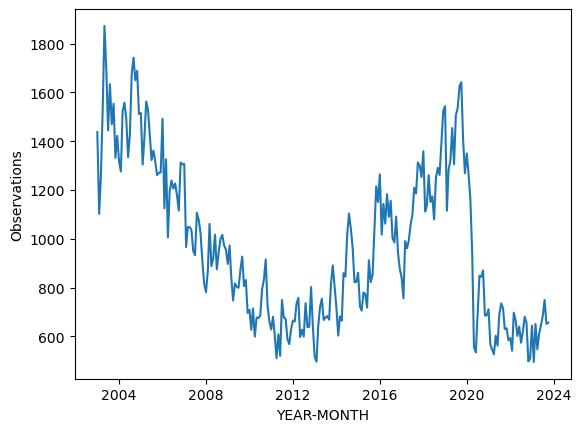

In [12]:
sns.lineplot(data=theft_from_vehicle, x='YEAR-MONTH', y='Observations')

In [13]:
theft_from_vehicle_filtered = theft_from_vehicle[['YEAR-MONTH','Observations']]
theft_from_vehicle_filtered.set_index('YEAR-MONTH', inplace=True)
theft_from_vehicle_filtered.head()

,Observations
YEAR-MONTH,
2003-01-01,1438
2003-02-01,1102
2003-03-01,1251
2003-04-01,1528
2003-05-01,1873


### Simple Moving Average & Exponential Smoothing

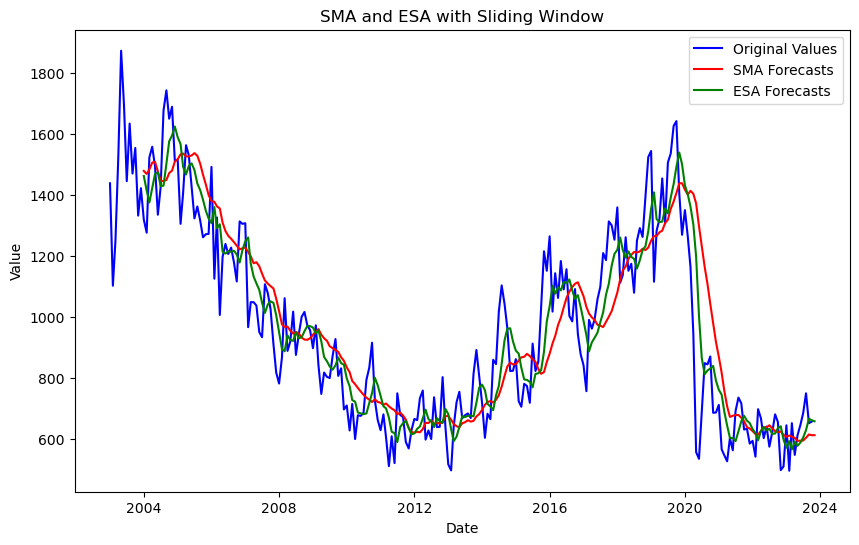

In [14]:
# Define the size of the sliding window
window_size = 12
# Define alpha (smoothing parameter in ES)
alpha=0.3

# Perform Simple Moving Average (SMA) and Exponential Smoothing (ES)
sma_values = []
smoothed_values = []
for i in range(len(theft_from_vehicle_filtered) - window_size + 1):
    
    window = theft_from_vehicle_filtered['Observations'].iloc[i:i+window_size]

    # SMA
    window_mean = window.mean()
    sma_values.append(window_mean)

    # ES
    smoothed_val = window.ewm(alpha=alpha, adjust=False).mean().iloc[-1]
    smoothed_values.append(smoothed_val)

# Construct dataframe for forecasted values
new_date = pd.to_datetime('2023-11-01')
forecasted_dates = theft_from_vehicle_filtered.index[window_size:]
forecasted_dates = forecasted_dates.append(pd.DatetimeIndex([new_date]))

sma_forecasted = pd.DataFrame({'SMA_Forecast': sma_values}, index=forecasted_dates)
esa_forecasted = pd.DataFrame({'ESA_Forecast': smoothed_values}, index=forecasted_dates)

# merge original and forecasted values into same dataframe
merged_df = pd.concat([theft_from_vehicle_filtered, sma_forecasted, esa_forecasted], axis=1)

# Plotting forecasted results
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['Observations'], label='Original Values', color='blue')
plt.plot(merged_df.index, merged_df['SMA_Forecast'], label='SMA Forecasts', color='red')
plt.plot(merged_df.index, merged_df['ESA_Forecast'], label='ESA Forecasts', color='green')
plt.legend()
plt.title('SMA and ESA with Sliding Window')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Based on a visual assessment of the Simple Moving Average (SMA) and Exponential Smoothing (ES) forecasts, it's evident that both methods broadly capture the general trend of the actual values. However, neither forecast method appears to be highly accurate. The Exponential Smoothing approach demonstrates a slightly improved performance compared to SMA.

### ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

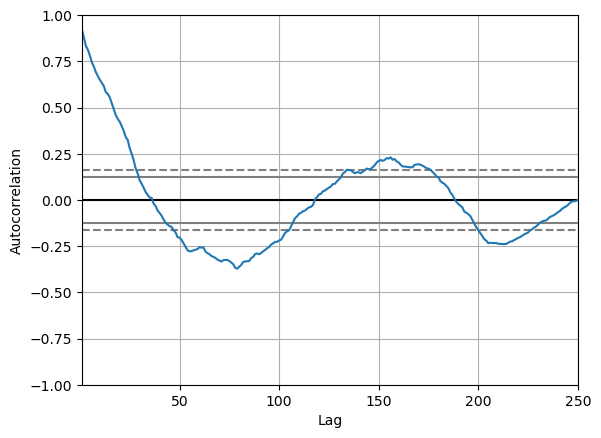

In [15]:
autocorrelation_plot(theft_from_vehicle.Observations)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

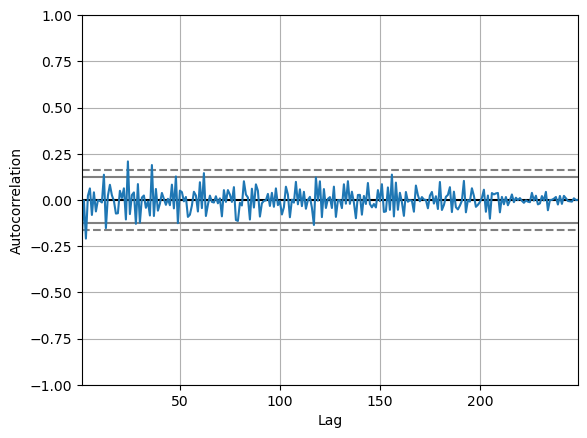

In [16]:
df_diff = theft_from_vehicle_filtered.diff().dropna() 
autocorrelation_plot(df_diff.Observations)

In [18]:
theft_from_vehicle_filtered

,Observations
YEAR-MONTH,
2003-01-01,1438
2003-02-01,1102
2003-03-01,1251
2003-04-01,1528
2003-05-01,1873
...,...
2023-06-01,645
2023-07-01,684
2023-08-01,749


In [17]:
# Adjust dataframe index inferred frequency
theft_from_vehicle_filtered.index = pd.DatetimeIndex(theft_from_vehicle_filtered.index.values, freq=theft_from_vehicle_filtered.index.inferred_freq)

# Define the size of the rolling window
window_size = 12 

# Perform ARIMA forecast with a rolling window
forecasted_values = []
for i in range(len(theft_from_vehicle_filtered) - window_size + 1):
    
    window = theft_from_vehicle_filtered['Observations'].iloc[i:i+window_size+1]
    
    model = ARIMA(window, order=(4, 1, 0))
    model_fit = model.fit()
    
    next_value = model_fit.forecast(steps=1).item()
    forecasted_values.append(next_value)

# Construct dataframe for forecasted value
new_date = pd.to_datetime('2023-11-01')
forecasted_dates = theft_from_vehicle_filtered.index[window_size:]
forecasted_dates = forecasted_dates.append(pd.DatetimeIndex([new_date]))

ARIMA_forecasted = pd.DataFrame({'ARIMA_Forecast': forecasted_values}, index=forecasted_dates)

# merge ARIMA forecasts to dataframe
merged_df = pd.concat([merged_df, ARIMA_forecasted], axis=1)
merged_df

,Observations,SMA_Forecast,ESA_Forecast,ARIMA_Forecast
2003-01-01,1438.0,NaN,NaN,NaN
2003-02-01,1102.0,NaN,NaN,NaN
2003-03-01,1251.0,NaN,NaN,NaN
2003-04-01,1528.0,NaN,NaN,NaN
2003-05-01,1873.0,NaN,NaN,NaN
...,...,...,...,...
2023-07-01,684.0,594.083333,603.749242,631.550408
2023-08-01,749.0,603.250000,628.475010,697.339737
2023-09-01,651.0,613.916667,665.449143,679.955980
2023-10-01,656.0,611.500000,660.768368,634.174521


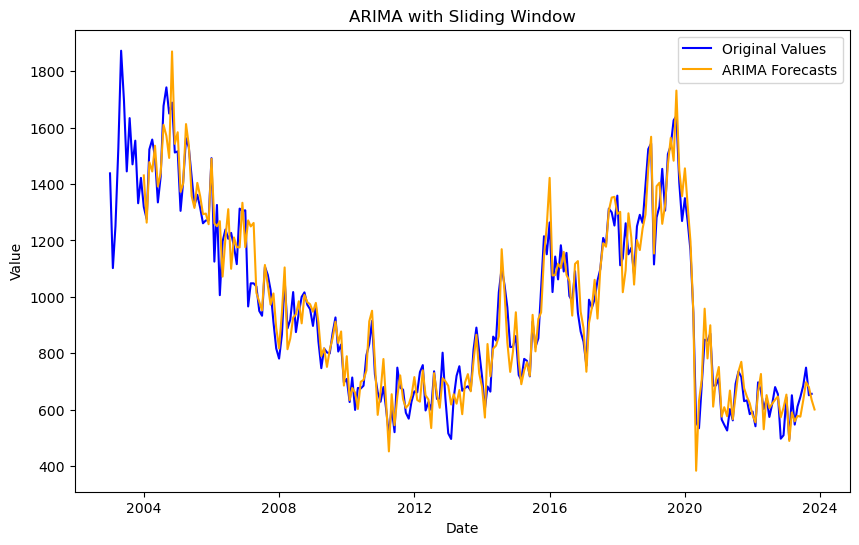

In [18]:
# Plotting the line plot with the ARIMA values
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['Observations'], label='Original Values', color='blue')
plt.plot(merged_df.index, merged_df['ARIMA_Forecast'], label='ARIMA Forecasts', color='orange')
plt.legend()
plt.title('ARIMA with Sliding Window')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

The forecast from the ARIMA model looks much better! We can see some clear overlaps between the forecasted value and the original value.

In [19]:
# Drop NA values to evaluate performance
merged_df_drop = merged_df.dropna()

results_df = get_metrics_from_df(merged_df_drop, "Observations")
results_df

,Forecast_Column,MAE,MSE
0,SMA_Forecast,121.216737,27239.951827
1,ESA_Forecast,98.641493,16240.436389
2,ARIMA_Forecast,59.279707,5970.333891


The displayed dataframe outlines the performance metrics, specifically the mean absolute error (MAE) and mean squared error (MSE), for the three models. Notably, there's a discernible pattern showcasing a marked enhancement in performance, progressing from Simple Moving Average (SMA) to Exponential Smoothing Approach (ESA) and ultimately to ARIMA. This consistent trend aligns with the observations gleaned from the visualizations crafted earlier, affirming the gradual improvement in forecasting accuracy across the models.

While the ARIMA model stands out as the most effective among the three forecasting models—simple moving average and exponential smoothing—it's crucial to acknowledge the room for enhancement in our predictive capabilities. Future advancements could entail fine-tuning the ARIMA hyperparameters or exploring alternative models to ascertain if further accuracy gains are attainable. Additionally, integrating exogenous variables, such as socioeconomic indicators or weather data, might augment the predictive power of our models, offering a more comprehensive understanding of crime dynamics. Furthermore, this analysis prompts future inquiries, including investigating the influence of specific external factors on crime occurrences or exploring spatial-temporal models to predict crime hotspots within Vancouver. These prospective avenues aim to refine our forecasting precision and deepen our insights into crime trends, paving the way for more informed law enforcement strategies and proactive crime prevention measures.

# References

Amanat, Hayatullah. “Vehicle Theft at a ‘critical Point’ in Canada: Report | CTV News.” CTVNews, CTV News, 17 June 2023, https://www.ctvnews.ca/canada/vehicle-theft-at-a-critical-point-in-canada-with-car-stolen-every-six-minutes-report-1.6443514.

Harris, C.R. et al., 2020. Array programming with NumPy. Nature, 585, pp.357–362.

J. D. Hunter, "Matplotlib: A 2D Graphics Environment," in Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, May-June 2007, doi: 10.1109/MCSE.2007.55.

McKinney, Wes. 2010. “Data Structures for Statistical Computing in Python.” In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51–56.

Pedregosa, F. et al., 2011. Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825–2830.

Seabold, Skipper, and Josef Perktold. “Statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

VanderPlas, J. et al., 2018. Altair: Interactive statistical visualizations for python. Journal of open source software, 3(32), p.1057.

“VPD OPEN DATA.” GeoDASH, Vancouver Police Department, https://geodash.vpd.ca/opendata/. Accessed 16 Nov. 2023.

Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021